# 분석주제

**이번 데이터 분석의 목표는 다음과 같은 2가지로 나눌 수 있다.**
1. 고개개 상태 및 서비스 이용 패턴을 기반으로 하여, 고객의 ***이탈 가능성을 예측하는 모델***을 만든다. 
2. 고객이 왜 서비스를 해지하는지, 고객이 ***이탈하는 이유***를 알아낸다.

In [1022]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # 경고 메시지 무시
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# 한글 폰트를 설정하여 시각화에 한글이 깨지지 않도록 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 데이터 불러오기

In [1023]:
import pandas as pd

In [1024]:
# Load datasets
status_analysis = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/Status_Analysis.csv")
service_options = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/service_options.csv")
online_services = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/online_services.csv")
payment_info = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/payment_info.csv")
location_data = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/location_data.csv")
customer_info = pd.read_csv("/Users/iyuseon/Desktop/archive (1)/customer_info.csv")

# 데이터 결합

Customer_Info (고객 id, 성별, 나이, 노인, 기혼, 부양 가족, 부양가족 수) : 데이터는 고객 개인 정보라 이탈예측에 필요 없다고 판단  
Location_Data (고객id, 국가, 소재지, 도시, 우편 번호, 총 인구, 위도, 경도) : 고객이 사는 장소에 대한 정보라 필요 없다고 판단  
  
> 분석 주제인 고객의 이탈 예측에는 필요없다고 판단하여 이번 분석에서는 사용하지 않기로 하였습니다. 


In [1025]:
# Merge datasets on customer_id
df = status_analysis.merge(service_options, on='customer_id')
df = df.merge(online_services, on='customer_id')
df = df.merge(payment_info, on='customer_id')

In [1026]:
df

,customer_id,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason,tenure,...,contract,paperless_billing,payment_method,monthly_ charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,0002-ORFBO,3,2205,Stayed,65,No,0,Not Applicable,NaN,9,...,One Year,Yes,Mailed check,65.60,42.39,593.30,0.00,0,381.51,974.81
1,0003-MKNFE,5,5414,Stayed,66,No,0,Not Applicable,NaN,9,...,Month-to-Month,No,Mailed check,59.90,10.69,542.40,38.33,10,96.21,610.28
2,0004-TLHLJ,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices,4,...,Month-to-Month,Yes,Electronic check,73.90,33.65,280.85,0.00,0,134.60,415.45
3,0011-IGKFF,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction,13,...,Month-to-Month,Yes,Electronic check,98.00,27.82,1237.85,0.00,0,361.66,1599.51
4,0013-EXCHZ,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability,3,...,Month-to-Month,Yes,Mailed check,83.90,7.38,267.40,0.00,0,22.14,289.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,4,3161,Stayed,59,No,0,Not Applicable,NaN,13,...,One Year,No,Mailed check,55.15,46.68,742.90,0.00,0,606.84,1349.74
7039,9992-RRAMN,1,5248,Churned,68,Yes,1,Dissatisfaction,Product dissatisfaction,22,...,Month-to-Month,Yes,Electronic check,85.10,16.20,1873.70,0.00,0,356.40,2230.10
7040,9992-UJOEL,5,5870,Joined,33,No,0,Not Applicable,NaN,2,...,Month-to-Month,Yes,Mailed check,50.30,18.62,92.75,0.00,0,37.24,129.99
7041,9993-LHIEB,3,4792,Stayed,59,No,0,Not Applicable,NaN,67,...,Two Year,No,Mailed check,67.85,2.12,4627.65,0.00,0,142.04,4769.69


# 데이터 정의

customer_id를 기준으로 병합한 결과 데이터는 38개의 열로 구성되어 있습니다.  
<custome_id> 고객 고유번호  
  
**status_analysis.csv**  
<satisfcation_score> 고객 만족도 점수 [ 1-매우불만족 ~ 5-매우만족 ]  
< cltv> 고객 생애 가치 - 고객이 우리 서비스를 이용하면서 우리 회사에 얼만큼의 이익을 가져다 주었는가? (정확한 단위 표시가 없어 확신할 수 없으나, 돈으로 환산했을 것이라 에상)  
<customer_status> 분기말 고객 상태 [해지, 유지, 신규가입]  
<churn_score> 고객이 서비스를 탈퇴/ 해지할 가능성 [ 0~100 ]  
<churn_label> 고객 서비스 해지 여부 [Yes, No]  
<churn_value> 고객 서비스 해지 여부 [ 0 - 해지하지 않음, 1 - 해지함 ]  
<churn_category> 해지 사유 [ 해지사유 미기입, 경쟁사, 고객 서비스 태도, 불만족, 가격, 기타 ]  
<churn_reason> 해지 사유 [ 경쟁사가 더 나은 기기를 보유, 경쟁사의 더 좋은 서비스, 고객 응대원의 태도, 모름 ]    
  
**service_options.csv**  
< tenure> 고객 가입 기간 (단위 : 달)  
<internet_service> 인터넷 가입 여부 [Yes, No]  
<phone_service> 핸드폰 가입 여부 [Yes, No]  
<multiple_lines> 한 계약 아래 두 개 이상의 회선 가입 여부 [Yes, No]   
<avg_monthly_gb_download> 월 평균 다운로드 용량 평균 (gb 기준)  
<unlimited_data> 무제한 요금제 사용 여부 [Yes, No]  
< offer> 고객이 받은 마지막 마케팅 제안 [None, Offer B, Offer E, Offer D, Offer A]  
<reffered_a_friend> 친구 추천 여부 [Yes, No]  
<number_of_referrals> 해당 고객의 추천으로 가입한 고객 수    
  
**payment_info.csv**  
< contract>  계약 유형 [개월 단위, 1년, 2년]  
<paperless_billing> 전자청구서 여부 [Yes, No]  
<payment_method> 결제 방식 [계좌이체, 카드, 수표]  
<monthly_charges> 서비스 이용에 따른 월 결제금액  
<avg_monthly_long_distance_charges> 월평균 장거리 전화 요금의 평균값  
<total_charges> 총 요금  
<total_refunds> 총 환불액  
<total_extra_data_charges> 초과 사용 데이터에 대한 추가 요금     
<total_long_distance_charges> 장거리 전화 요금의 합계     
   
**online_services.csv**  
<phone_service> 전화선 가입 여부 [Yes, No]  
<internet_service> 인터넷 가입 여부 [Yes, No]  
<online_security> 보안 서비스 가입 여부 [Yes, No]  
<online_backup> 백업 서비스 구독 여부 [Yes, No]  
<device_protection> 기기 보호 플랜 가입 여부 [Yes, No]  
<premium_tech_support> 프리미엄 기술 지원 서비스 가입 여부 [Yes, No]  
<streaming_tv> 티비 스트리밍 서비스 가입 여부 [Yes, No]  
<streaming_movies> 영화 스트리밍 서비스 가입 여부 [Yes, No]  
<streaming_music> 음악 스트리밍 서비스 가입 여부 [Yes, No]    



# 불필요한 컬럼 삭제

칼럼 확인 결과 churn_label, churn_score, churn_value는 다 같은 내용을 담은 칼럼이라 판단하여 수치형 데이터로 표시되어 있는 churn value만 사용하기로 하고, 천라벨 데이터와 스코어는 drop 하였다. 

In [1027]:
df = df.drop(columns=['churn_label']) 
df = df.drop(columns=['churn_score'])
# Churn Value -> 목표 변수

# 기본 통계 확인

In [1029]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   satisfaction_score                 7043 non-null   int64  
 2   cltv                               7043 non-null   int64  
 3   customer_status                    7043 non-null   object 
 4   churn_value                        7043 non-null   int64  
 5   churn_category                     7043 non-null   object 
 6   churn_reason                       1869 non-null   object 
 7   tenure                             7043 non-null   int64  
 8   internet_service_x                 7043 non-null   object 
 9   phone_service_x                    7043 non-null   object 
 10  multiple_lines                     7043 non-null   object 
 11  avg_monthly_gb_download            7043 non-null   int64

# 불필요한 컬럼 삭제

In [1030]:
df = df.drop(columns=['customer_id'])

In [1031]:
df = df.drop(columns=['churn_reason'])

In [1032]:
df = df.drop(columns=['internet_service_y'])
df = df.drop(columns=['phone_service_y'])

In [1033]:
df.head()

,satisfaction_score,cltv,customer_status,churn_value,churn_category,tenure,internet_service_x,phone_service_x,multiple_lines,avg_monthly_gb_download,...,contract,paperless_billing,payment_method,monthly_ charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
0,3,2205,Stayed,0,Not Applicable,9,Yes,Yes,No,16,...,One Year,Yes,Mailed check,65.6,42.39,593.30,0.00,0,381.51,974.81
1,5,5414,Stayed,0,Not Applicable,9,Yes,Yes,Yes,10,...,Month-to-Month,No,Mailed check,59.9,10.69,542.40,38.33,10,96.21,610.28
2,1,4479,Churned,1,Competitor,4,Yes,Yes,No,30,...,Month-to-Month,Yes,Electronic check,73.9,33.65,280.85,0.00,0,134.60,415.45
3,1,3714,Churned,1,Dissatisfaction,13,Yes,Yes,No,4,...,Month-to-Month,Yes,Electronic check,98.0,27.82,1237.85,0.00,0,361.66,1599.51
4,1,3464,Churned,1,Dissatisfaction,3,Yes,Yes,No,11,...,Month-to-Month,Yes,Mailed check,83.9,7.38,267.40,0.00,0,22.14,289.54


# 컬럼 확인 및 라벨인코딩

In [1034]:
df['satisfaction_score'].value_counts()

satisfaction_score
3    2665
4    1789
5    1149
1     922
2     518
Name: count, dtype: int64

In [1035]:
df['cltv'].value_counts()                     

cltv
5546    8
4741    7
4745    7
4369    7
4115    7
       ..
4557    1
4833    1
4692    1
3327    1
5639    1
Name: count, Length: 3438, dtype: int64

In [1036]:
df['customer_status'].value_counts()                     

customer_status
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

In [1037]:
df.isnull().sum()

satisfaction_score                      0
cltv                                    0
customer_status                         0
churn_value                             0
churn_category                          0
tenure                                  0
internet_service_x                      0
phone_service_x                         0
multiple_lines                          0
avg_monthly_gb_download                 0
unlimited_data                          0
offer                                3877
referred_a_friend                       0
number_of_referrals                     0
online_security                         0
online_backup                           0
device_protection                       0
premium_tech_support                    0
streaming_tv                            0
streaming_movies                        0
streaming_music                         0
internet_type                        1526
contract                                0
paperless_billing                 

# 범주형 컬럼으로 라벨인코딩 실행

In [1038]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [1039]:
df['customer_status'] = le.fit_transform(df['customer_status'])
df['customer_status'].value_counts()

customer_status
2    4720
0    1869
1     454
Name: count, dtype: int64

In [1040]:
df['churn_value'].value_counts()                     

churn_value
0    5174
1    1869
Name: count, dtype: int64

In [1041]:
df['churn_category'].value_counts()  

churn_category
Not Applicable     5174
Competitor          841
Attitude            314
Dissatisfaction     303
Price               211
Other               200
Name: count, dtype: int64

In [1042]:
df['churn_category'] = le.fit_transform(df['churn_category'])
df['churn_category'].value_counts()

# 3 (기록없음) 1 (경쟁사) 0 (태도) 2 (만족도) 5 (가격) 4 (기타)

churn_category
3    5174
1     841
0     314
2     303
5     211
4     200
Name: count, dtype: int64

In [1043]:
df['tenure'].value_counts()  

tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

In [1044]:
df['internet_service_x'].value_counts()  

internet_service_x
Yes    5517
No     1526
Name: count, dtype: int64

In [1045]:
df['internet_service'] = le.fit_transform(df['internet_service_x'])
df = df.drop(columns=['internet_service_x'])
df['internet_service'].value_counts()  

internet_service
1    5517
0    1526
Name: count, dtype: int64

In [1046]:
df['phone_service_x'].value_counts()  

phone_service_x
Yes    6361
No      682
Name: count, dtype: int64

In [1047]:
df['phone_service'] = le.fit_transform(df['phone_service_x'])
df = df.drop(columns=['phone_service_x'])
df['phone_service'].value_counts()  

phone_service
1    6361
0     682
Name: count, dtype: int64

In [1048]:
df['multiple_lines'].value_counts()  

multiple_lines
No     4072
Yes    2971
Name: count, dtype: int64

In [1049]:
df['multiple_lines'] = le.fit_transform(df['multiple_lines'])
df['multiple_lines'].value_counts()  

multiple_lines
0    4072
1    2971
Name: count, dtype: int64

In [1050]:
df['avg_monthly_gb_download'].value_counts()  

avg_monthly_gb_download
0     1526
19     220
27     199
30     193
59     192
26     191
23     179
22     172
21     171
18     164
13     164
17     155
16     155
20     151
24     148
28     147
11     145
12     143
29     138
15     132
10     132
14     131
25     130
3      130
4      129
52     121
8      120
7      116
9      116
2      116
5      114
6      114
51      90
53      88
48      86
73      81
69      75
41      67
76      58
85      48
58      45
42      45
82      43
71      42
47      36
57      34
46      19
56      16
75      15
39       1
Name: count, dtype: int64

In [1051]:
df['unlimited_data'].value_counts()  

unlimited_data
Yes    4745
No     2298
Name: count, dtype: int64

In [1052]:
df['unlimited_data'] = le.fit_transform(df['unlimited_data'])
df['unlimited_data'].value_counts()  

unlimited_data
1    4745
0    2298
Name: count, dtype: int64

In [1053]:
df['offer'].value_counts()  

offer
Offer B    824
Offer E    805
Offer D    602
Offer A    520
Offer C    415
Name: count, dtype: int64

In [1054]:
df['offer'] = le.fit_transform(df['offer'])
df['offer'].value_counts()  

offer
5    3877
1     824
4     805
3     602
0     520
2     415
Name: count, dtype: int64

In [1055]:
df['referred_a_friend'].value_counts()  

referred_a_friend
No     3821
Yes    3222
Name: count, dtype: int64

In [1056]:
df['referred_a_friend'] = le.fit_transform(df['referred_a_friend'])
df['referred_a_friend'].value_counts()  

referred_a_friend
0    3821
1    3222
Name: count, dtype: int64

In [1057]:
df['number_of_referrals'].value_counts()  

number_of_referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
2      236
4      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64

In [1058]:
df['online_security'].value_counts()  

online_security
No     5024
Yes    2019
Name: count, dtype: int64

In [1059]:
df['online_security'] = le.fit_transform(df['online_security'])
df['online_security'].value_counts() 

online_security
0    5024
1    2019
Name: count, dtype: int64

In [1060]:
df['online_backup'].value_counts()  

online_backup
No     4614
Yes    2429
Name: count, dtype: int64

In [1061]:
df['online_backup'] = le.fit_transform(df['online_backup'])
df['online_backup'].value_counts() 

online_backup
0    4614
1    2429
Name: count, dtype: int64

In [1062]:
df['device_protection'].value_counts()  

device_protection
No     4621
Yes    2422
Name: count, dtype: int64

In [1063]:
df['device_protection'] = le.fit_transform(df['device_protection'])
df['device_protection'].value_counts() 

device_protection
0    4621
1    2422
Name: count, dtype: int64

In [1064]:
df['premium_tech_support'].value_counts() 

premium_tech_support
No     4999
Yes    2044
Name: count, dtype: int64

In [1065]:
df['premium_tech_support'] = le.fit_transform(df['premium_tech_support'])
df['premium_tech_support'].value_counts() 

premium_tech_support
0    4999
1    2044
Name: count, dtype: int64

In [1066]:
df['streaming_tv'].value_counts() 

streaming_tv
No     4336
Yes    2707
Name: count, dtype: int64

In [1067]:
df['streaming_tv'] = le.fit_transform(df['streaming_tv'])
df['streaming_tv'].value_counts() 

streaming_tv
0    4336
1    2707
Name: count, dtype: int64

In [1068]:
df['streaming_movies'].value_counts() 

streaming_movies
No     4311
Yes    2732
Name: count, dtype: int64

In [1069]:
df['streaming_movies'] = le.fit_transform(df['streaming_movies'])
df['streaming_movies'].value_counts() 

streaming_movies
0    4311
1    2732
Name: count, dtype: int64

In [1070]:
df['streaming_music'].value_counts() 

streaming_music
No     4555
Yes    2488
Name: count, dtype: int64

In [1071]:
df['streaming_music'] = le.fit_transform(df['streaming_music'])
df['streaming_music'].value_counts() 

streaming_music
0    4555
1    2488
Name: count, dtype: int64

In [1072]:
df['internet_type'].value_counts() 

internet_type
Fiber Optic    3035
DSL            1652
Cable           830
Name: count, dtype: int64

In [1073]:
df['internet_type'] = le.fit_transform(df['internet_type'])
df['internet_type'].value_counts() 

internet_type
2    3035
1    1652
3    1526
0     830
Name: count, dtype: int64

In [1074]:
df['contract'].value_counts() 

contract
Month-to-Month    3610
Two Year          1883
One Year          1550
Name: count, dtype: int64

In [1075]:
df['contract'] = le.fit_transform(df['contract'])
df['contract'].value_counts() 

contract
0    3610
2    1883
1    1550
Name: count, dtype: int64

In [1076]:
df['paperless_billing'].value_counts() 

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64

In [1077]:
df['paperless_billing'] = le.fit_transform(df['paperless_billing'])
df['paperless_billing'].value_counts() 

paperless_billing
1    4171
0    2872
Name: count, dtype: int64

In [1078]:
df['payment_method'].value_counts() 

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

In [1079]:
df['payment_method'] = le.fit_transform(df['payment_method'])
df['payment_method'].value_counts() 

payment_method
2    2365
3    1612
0    1544
1    1522
Name: count, dtype: int64

In [1080]:
df['monthly_ charges'].value_counts() 

monthly_ charges
20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
116.55     1
106.85     1
68.55      1
108.80     1
67.85      1
Name: count, Length: 1585, dtype: int64

In [1081]:
df['avg_monthly_long_distance_charges'].value_counts() 

avg_monthly_long_distance_charges
0.00     682
18.26      7
30.07      6
45.92      6
30.09      6
        ... 
32.23      1
22.26      1
47.03      1
42.21      1
2.01       1
Name: count, Length: 3584, dtype: int64

In [1082]:
df['total_charges'].value_counts() 

total_charges
20.20      11
19.75       9
19.90       8
20.05       8
19.65       8
           ..
829.55      1
625.65      1
462.80      1
251.25      1
3707.60     1
Name: count, Length: 6540, dtype: int64

In [1083]:
df['total_refunds'].value_counts() 

total_refunds
0.00     6518
16.56       2
8.74        2
1.31        2
41.74       2
         ... 
31.90       1
12.07       1
37.37       1
48.59       1
10.20       1
Name: count, Length: 500, dtype: int64

In [1084]:
df['total_extra_data_charges'].value_counts() 

total_extra_data_charges
0      6315
10      138
40       62
30       58
20       51
80       47
100      44
50       43
150      42
130      40
140      38
60       36
90       35
70       34
110      32
120      28
Name: count, dtype: int64

In [1085]:
df['total_long_distance_charges'].value_counts() 

total_long_distance_charges
0.00       682
15.60        4
48.96        4
22.86        4
597.60       3
          ... 
200.75       1
217.62       1
2288.43      1
1417.68      1
142.04       1
Name: count, Length: 6068, dtype: int64

In [1086]:
df['total_revenue'].value_counts() 

total_revenue
24.80      3
116.27     3
68.41      3
66.56      3
3386.40    2
          ..
976.70     1
300.65     1
3258.42    1
1713.52    1
3707.60    1
Name: count, Length: 6975, dtype: int64

In [1087]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   satisfaction_score                 7043 non-null   int64  
 1   cltv                               7043 non-null   int64  
 2   customer_status                    7043 non-null   int64  
 3   churn_value                        7043 non-null   int64  
 4   churn_category                     7043 non-null   int64  
 5   tenure                             7043 non-null   int64  
 6   multiple_lines                     7043 non-null   int64  
 7   avg_monthly_gb_download            7043 non-null   int64  
 8   unlimited_data                     7043 non-null   int64  
 9   offer                              7043 non-null   int64  
 10  referred_a_friend                  7043 non-null   int64  
 11  number_of_referrals                7043 non-null   int64

# 시각화

In [1088]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

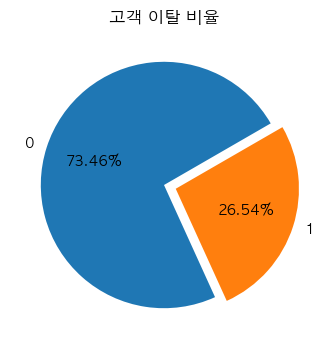

In [1089]:
# 종속변수 시각화
Flag = df['churn_value'].value_counts()

plt.figure(figsize=(9,4))
plt.pie(Flag, labels=Flag.index, autopct='%1.2f%%',
        startangle=30, explode=[0, 0.1])
plt.title("고객 이탈 비율")
plt.show()

**- 종속변수인 churn value는 이탈한 고객 26.54% 유지 고객은 73.46%로 분포되어 있음을 알 수 있다.**

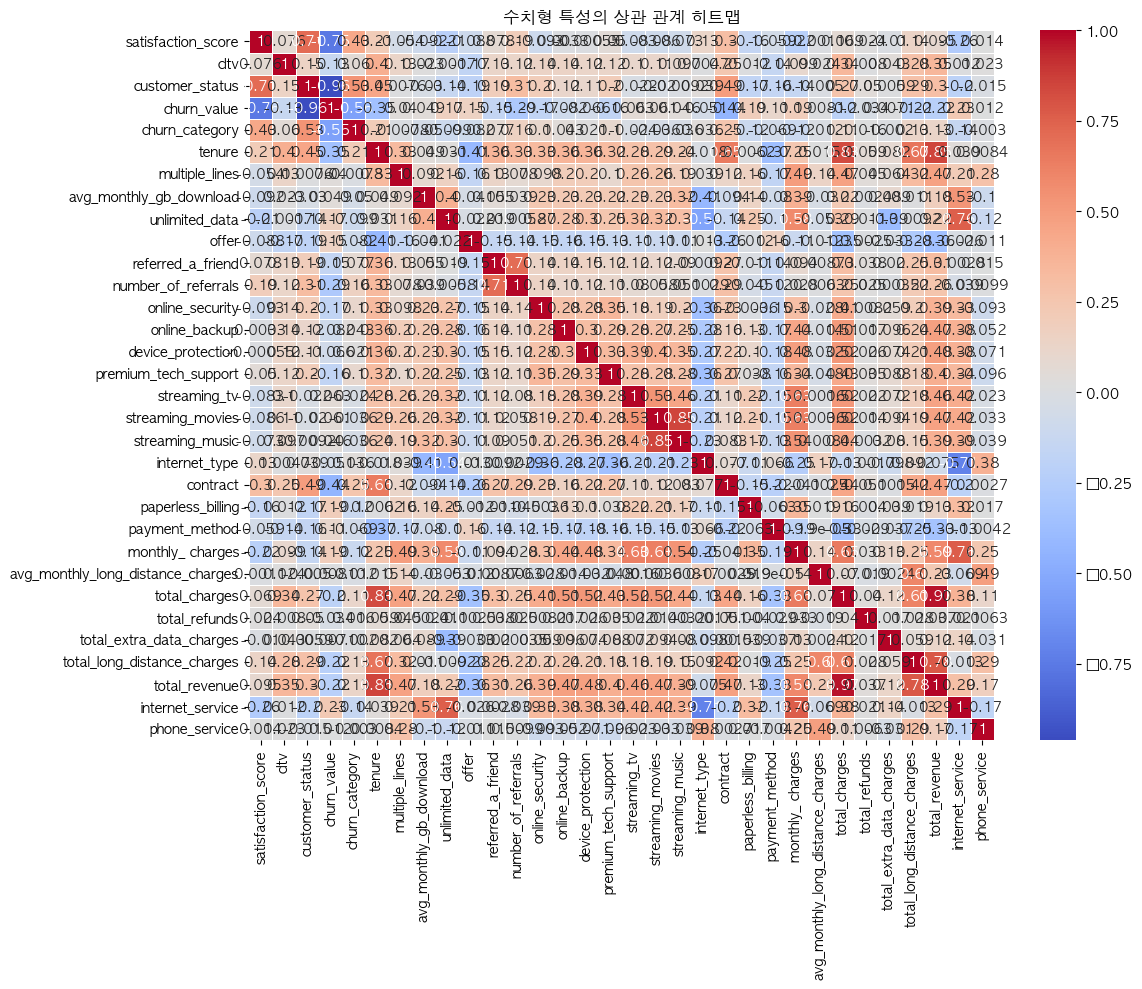

In [1090]:
# 수치형 특성의 상관 관계 히트맵 시각화 (수치형 컬럼만 사용)

numeric_data = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('수치형 특성의 상관 관계 히트맵')
plt.tight_layout()
plt.show()

In [1091]:
# int 데이터 타입을 'cat_col'에 추가
num_col = []
for col in df.columns:
    if df[col].dtype in ['int', 'float']:
        num_col.append(col)
print(num_col)

['satisfaction_score', 'cltv', 'customer_status', 'churn_value', 'churn_category', 'tenure', 'multiple_lines', 'avg_monthly_gb_download', 'unlimited_data', 'offer', 'referred_a_friend', 'number_of_referrals', 'online_security', 'online_backup', 'device_protection', 'premium_tech_support', 'streaming_tv', 'streaming_movies', 'streaming_music', 'internet_type', 'contract', 'paperless_billing', 'payment_method', 'monthly_ charges', 'avg_monthly_long_distance_charges', 'total_charges', 'total_refunds', 'total_extra_data_charges', 'total_long_distance_charges', 'total_revenue', 'internet_service', 'phone_service']


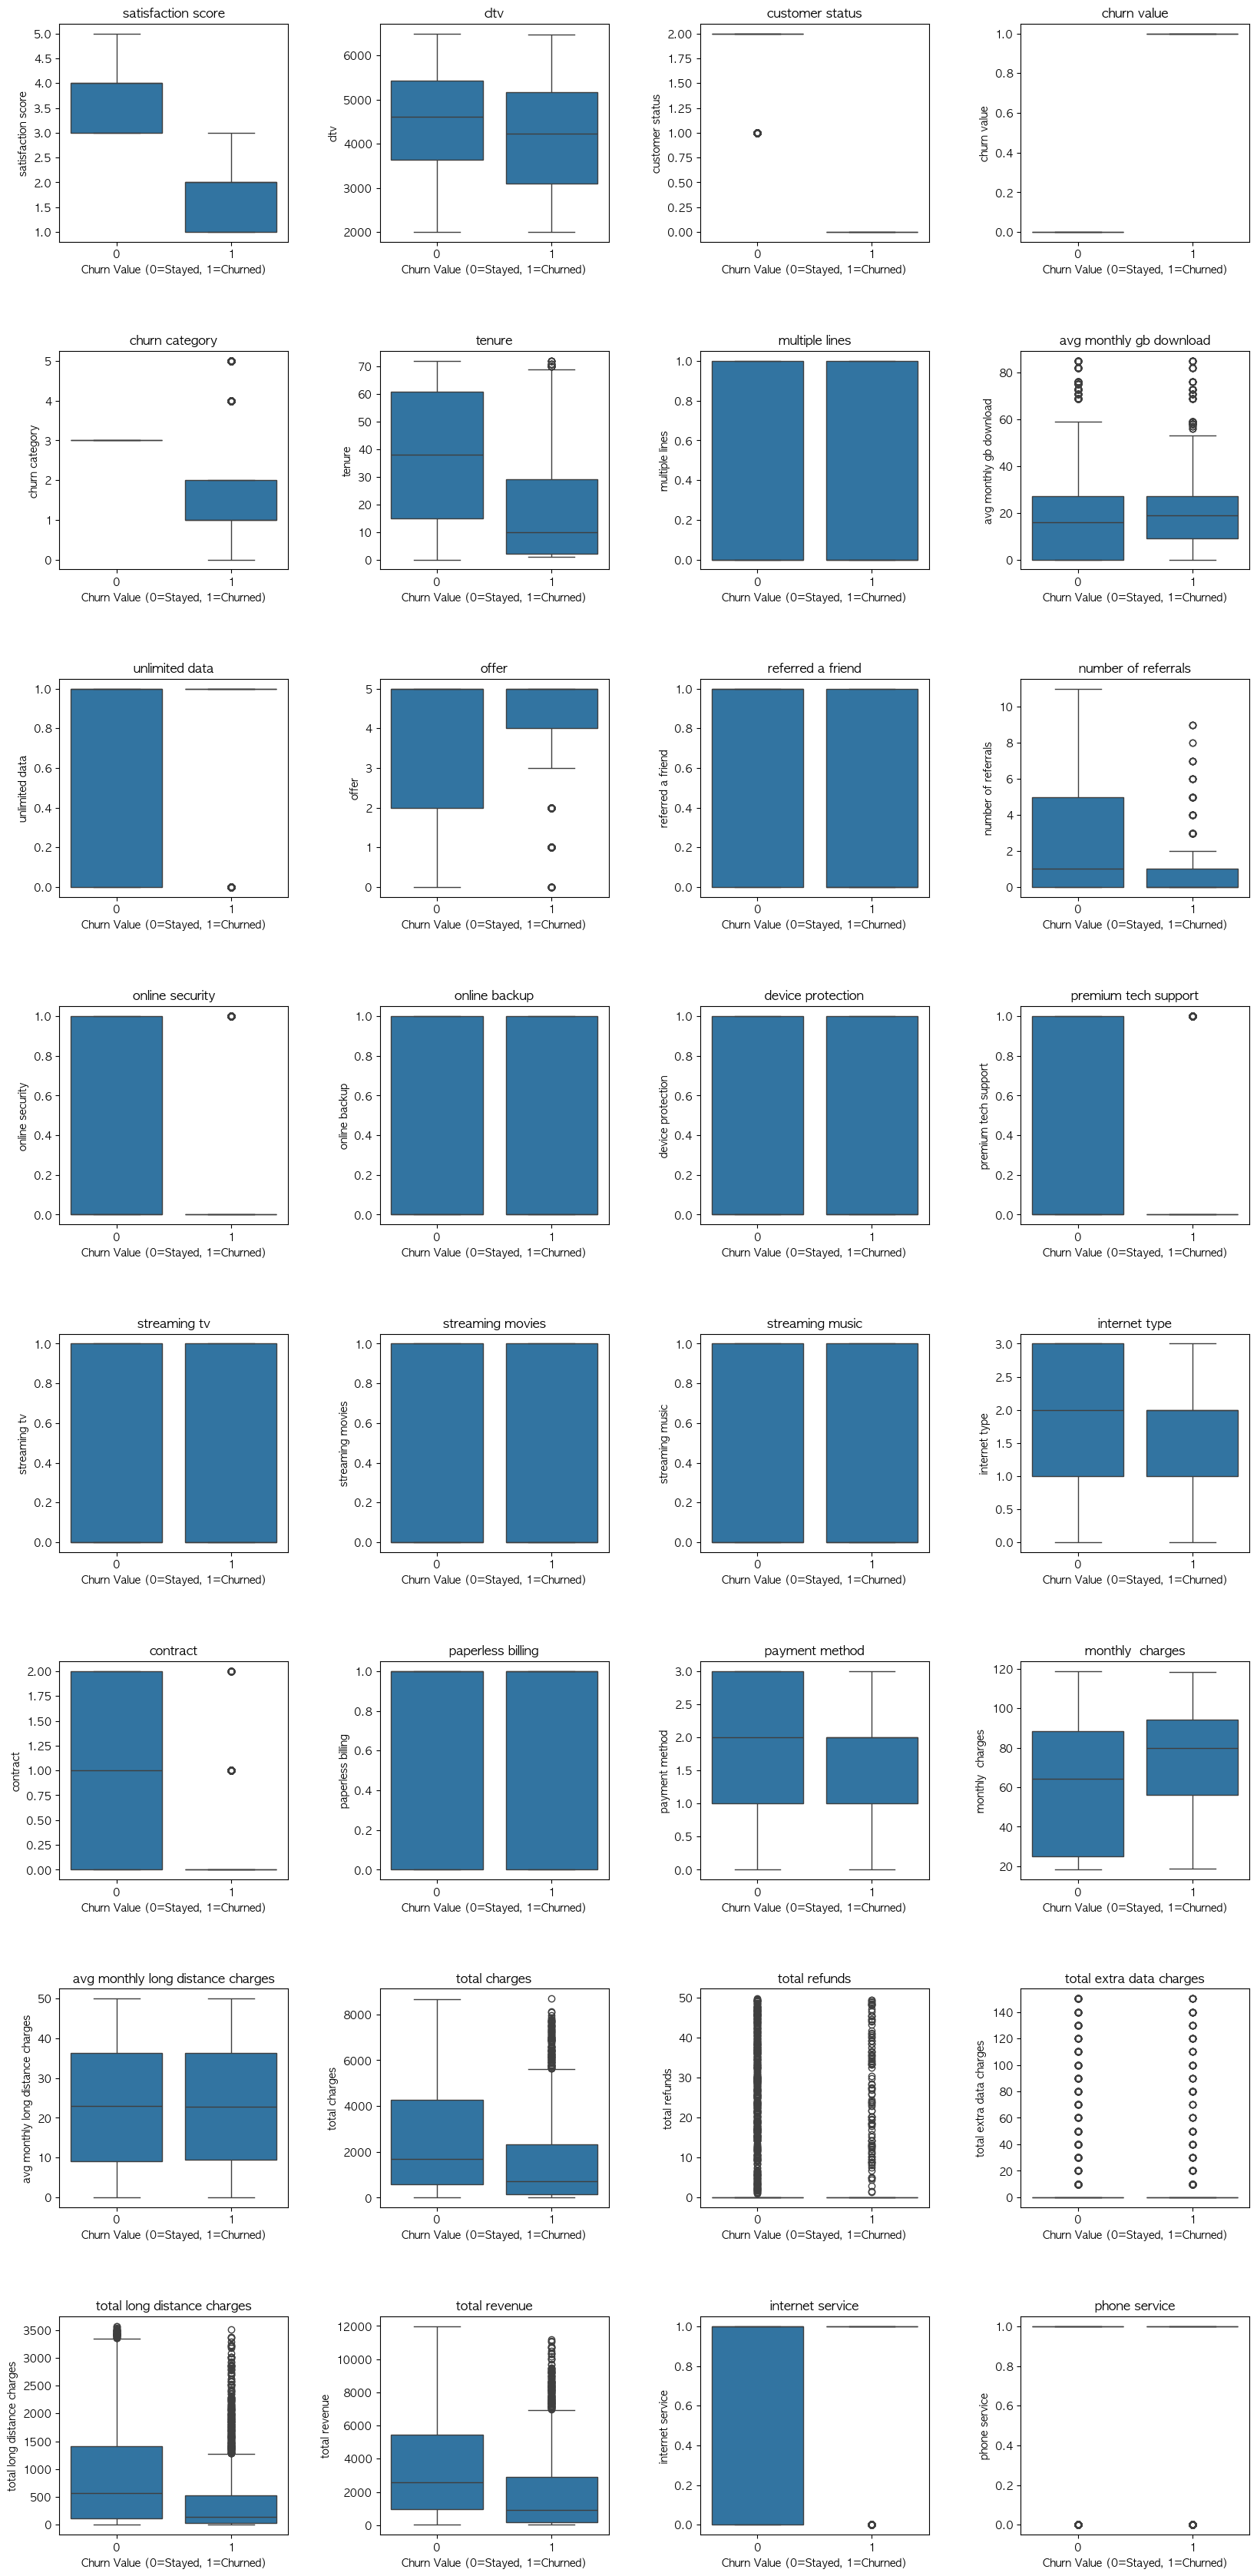

In [1092]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 컬럼을 기반으로 박스플롯 시각화
figure2, axes_array2 = plt.subplots(len(num_col) // 4 + 1, 4, figsize=(20, len(num_col) * 1.5))
plt.subplots_adjust(hspace=0.5, wspace=0.4)  # 서브플롯 간 간격 조정

# 1D 형태의 서브플롯 배열로 변환 (빈 칸 제거를 위해)
axes = axes_array2.flatten()

# 데이터 시각화
for i, col in enumerate(num_col):
    sns.boxplot(data=df, x='churn_value', y=col, ax=axes[i])
    axes[i].set_title(f"{col.replace('_', ' ')}")
    axes[i].set_xlabel('Churn Value (0=Stayed, 1=Churned)')
    axes[i].set_ylabel(col.replace('_', ' '))

# 남은 빈 서브플롯 제거
for j in range(i + 1, len(axes)):
    figure2.delaxes(axes[j])

plt.show()

**satisfaction_score**  
유지(0) 고객은 높은 만족도를 보이는 반면 이탈(1) 고객은 낮은 만족도를 보임  
이탈 여부에 강한 상관관계를 가지며 매우 중요한 변수  

**cltv**  
유지(0)와 이탈(1) 고객 간의 분포 차이가 크지 않음  
중요한 변수로 작용하지 않을 가능성이 높음  

**customer_status**  
유지(0)와 이탈(1)을 명확히 구분  
타겟 변수와 직접적으로 연관된 중요한 변수  

**churn_category**  
이탈(1) 고객만 값을 가지며 이탈 이유를 분류  
이탈 원인 분석과 고객 맞춤 전략 설계에 중요한 역할  

**tenure**  
유지(0) 고객은 가입 기간이 긴 경향을 보이며 이탈(1) 고객은 가입 기간이 짧음  
이탈 가능성을 나타내는 중요한 변수  

**multiple_lines**  
유지(0)와 이탈(1) 고객 간 분포 차이 없음  
다회선 사용 여부는 이탈 여부와 낮은 상관관계  

**avg_monthly_gb_download**  
유지(0)와 이탈(1) 고객 간 큰 차이가 없음  
고객 이탈 여부와 상관성이 낮은 변수로 판단  

**unlimited_data**  
유지(0) 고객은 무제한 데이터 요금제를 선택하는 경우가 많음  
무제한 데이터 요금제는 고객 유지를 높이는 데 긍정적인 영향  

**offer**  
유지(0) 고객은 다양한 혜택(Offer A~E)을 받는 경우가 많음  
마케팅 혜택은 고객 유지를 높이는 주요 요인으로 작용  

**referred_a_friend**  
유지(0)와 이탈(1) 고객 간 차이가 크지 않음  
친구 추천 여부는 이탈 여부와 낮은 상관관계  

**number_of_referrals**  
유지(0) 고객은 추천 횟수가 많으며 이탈(1) 고객은 추천 횟수가 적음  
추천 횟수는 고객 만족도와 연결될 가능성이 높음  

**online_security**  
유지(0) 고객은 온라인 보안 서비스를 많이 이용하며 이탈(1) 고객은 거의 이용하지 않음  
온라인 보안 서비스는 이탈을 방지하는 데 중요한 변수  

**online_backup**  
유지(0) 고객은 온라인 백업 서비스를 많이 이용  
백업 서비스 이용 여부는 고객 유지에 긍정적인 영향  

**device_protection**  
유지(0) 고객은 기기 보호 플랜을 많이 선택하며 이탈(1) 고객은 적게 선택  
고객 만족도와 유지율을 높이는 데 기여할 가능성이 있음  

**premium_tech_support**  
유지(0) 고객은 기술 지원 서비스를 많이 이용하며 이탈(1) 고객은 거의 이용하지 않음  
은 고객 유지를 위한 주요 서비스 보임  

**streaming_tv, streaming_movies, streaming_music**  
유지(0)와 이탈(1) 고객 간의 분포 차이가 크지 않음  
스트리밍 서비스 사용 여부는 이탈 여부에 중요한 영향을 미치지 않을 가능성이 큼  

**contract**  
유지(0) 고객은 장기 계약(1년, 2년)을 선택하는 경우가 많으며 이탈(1) 고객은 단기 계약(월 단위)을 선택  
계약 기간은 이탈 방지의 중요한 변수로 작용  
  
**paperless_billing**  
전자 청구서를 선택한 고객은 이탈 가능성이 더 높음  
종이 청구서 이용 고객은 유지 가능성이 더 높음  

**payment_method**  
유지(0) 고객은 다양한 결제 방법을 선택하는 경향  
결제 방식은 고객 만족도와 약간의 상관관계  

**monthly_charges**  
이탈(1) 고객은 평균적으로 높은 월 청구 금액을 지불하며 이는 이탈 가능성을 높이는 원인일 수 있음  

**total_charges**  
유지(0) 고객은 총 청구 금액이 높은 경향  
장기 가입 고객이 유지 가능성이 높음을 보여줌  

**total_refunds**  
이탈(1) 고객은 환불 기록을 가진 경우가 많음  
환불 여부는 이탈을 예측하는 중요한 지표  

**internet_service**  
유지(0) 고객은 고속 인터넷(Fiber Optic)을 이용하는 비율이 높음  
인터넷 서비스 유형은 고객 유지와 관련될 가능성이 높음  

**total_revenue**  
유지(0) 고객은 더 높은 매출 기여도  
장기 고객이 기업 수익에 중요한 영향  

**아래와 같은 경우에 이탈하는 고객이 많음을 알 수 있다.**
- 고객의 가입기간이 짧은 경우
- 무제한 데이터 요금제를 사용하지 않는 경우 
- 다양한  혜택을 받지 못하는 경우
- 추천횟수가 적은 경우
- 온라인 보안 서비스를 이용하지 않은 경우 
- 백업 서비스를 이용하지 않은 경우
- 프리미엄 기술 지원 서비스를 이용하지 않은 경우
- 기기 보호 플랜을 선택하지 않은 경우 
- 월 평균 청구금액이 높은 경우   

# 랜덤포레스트로 속성중요도 확인

In [1093]:
y = df['churn_value']  # 이탈 여부 (0: Stayed, 1: Churned)
X = df.drop(columns=['churn_value'])

In [1094]:
from sklearn.model_selection import train_test_split

# 데이터 분리 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1095]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# 랜덤 포레스트 모델 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 피처 중요도 추출
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance'])

# 중요도 내림차순 정렬
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# 출력
print(feature_importances)


                                   importance
customer_status                      0.332358
churn_category                       0.302189
satisfaction_score                   0.251427
contract                             0.027874
number_of_referrals                  0.015355
tenure                               0.013119
total_long_distance_charges          0.008900
monthly_ charges                     0.008822
total_charges                        0.007486
total_revenue                        0.005987
avg_monthly_gb_download              0.005123
internet_type                        0.003655
internet_service                     0.002401
payment_method                       0.002194
cltv                                 0.001903
paperless_billing                    0.001809
premium_tech_support                 0.001753
avg_monthly_long_distance_charges    0.001703
online_security                      0.001288
offer                                0.001029
unlimited_data                    

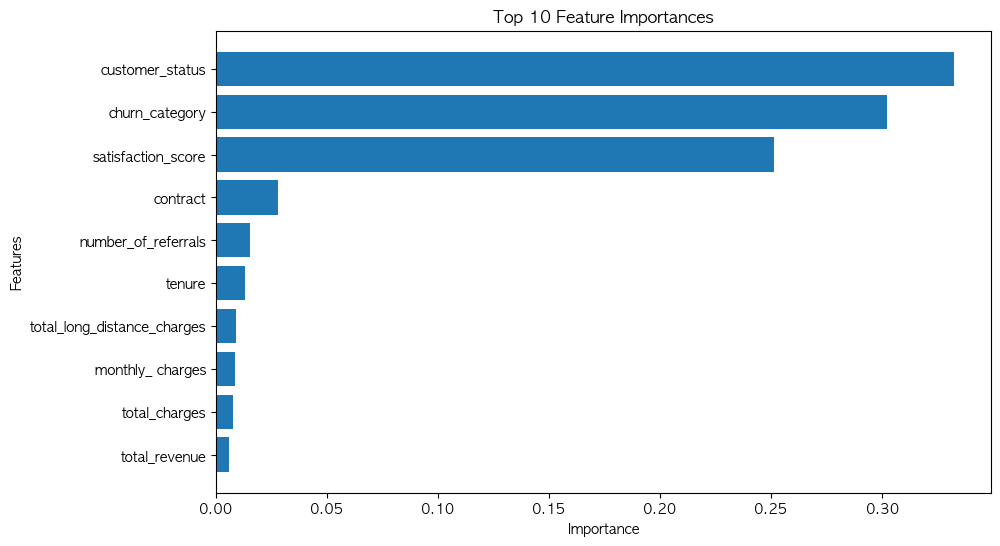

In [1096]:

# 상위 10개 중요한 변수 시각화
top_features = feature_importances.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features.index, top_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # 상위 중요도를 위로 정렬
plt.show()

# 상관관계 분석

타겟 변수와 상관관계가 높은 변수들:
 churn_value                          1.000000
customer_status                      0.961143
satisfaction_score                   0.754649
churn_category                       0.554883
contract                             0.435398
tenure                               0.352229
number_of_referrals                  0.286540
internet_service                     0.227890
total_long_distance_charges          0.223756
total_revenue                        0.223003
total_charges                        0.198546
monthly_ charges                     0.193356
paperless_billing                    0.191825
online_security                      0.171226
unlimited_data                       0.166545
premium_tech_support                 0.164674
offer                                0.151112
referred_a_friend                    0.149122
cltv                                 0.127463
payment_method                       0.107062
online_backup                        0.082255
device_prote

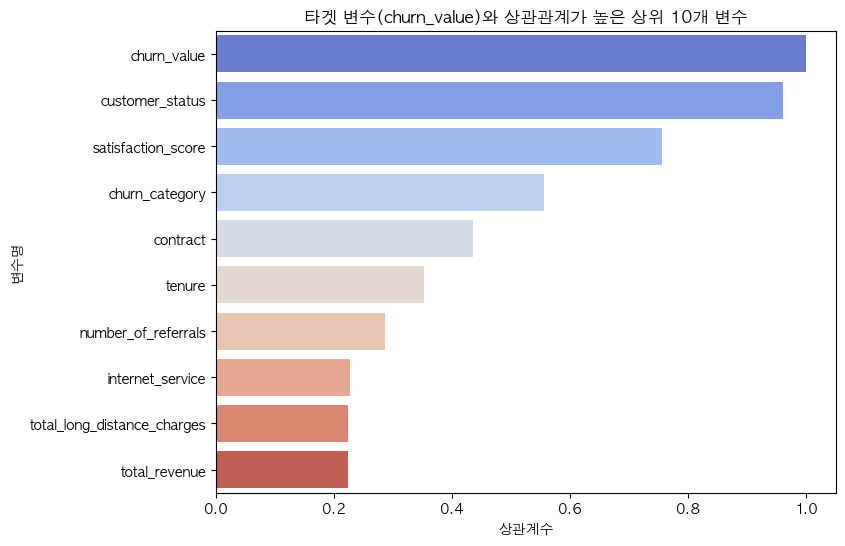

In [1097]:

# 타겟 변수 설정
target_variable = "churn_value"

# 상관관계 계산
correlation_matrix = df.corr().abs() # 전체 변수 간 상관관계
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)  # 타겟과 상관관계 정렬

# 결과 출력
print("타겟 변수와 상관관계가 높은 변수들:\n", correlation_with_target )

# 상위 10개 변수 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_target[:10], y=correlation_with_target.index[:10], palette="coolwarm")
plt.title("타겟 변수(churn_value)와 상관관계가 높은 상위 10개 변수")
plt.xlabel("상관계수")
plt.ylabel("변수명")
plt.show()

In [1098]:

# 타겟 변수 설정
target_variable = "churn_value"

# 상관관계 계산
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)  # 타겟과 상관관계 정렬

# 결과 출력
print("타겟 변수와 상관관계가 높은 변수들(절댓값x):\n", correlation_with_target )

plt.show()

타겟 변수와 상관관계가 높은 변수들(절댓값x):
 churn_value                          1.000000
internet_service                     0.227890
monthly_ charges                     0.193356
paperless_billing                    0.191825
unlimited_data                       0.166545
offer                                0.151112
payment_method                       0.107062
streaming_tv                         0.063228
streaming_movies                     0.061382
avg_monthly_gb_download              0.048868
streaming_music                      0.045587
multiple_lines                       0.040102
phone_service                        0.011942
avg_monthly_long_distance_charges    0.008120
total_extra_data_charges             0.007139
total_refunds                       -0.033709
internet_type                       -0.050694
device_protection                   -0.066160
online_backup                       -0.082255
cltv                                -0.127463
referred_a_friend                   -0.149122
premiu

<상관계수 분석 결과>  
 : customer_status (0.96) satisfaction_score (0.75) churn_category (0.554883) 이 3개의 칼럼이 종속변수와 가장 높은 상관관계를 보였다.     
   
그렇지만 customer_status의 경우 상관계수가 0.96인 것을 보아 두 데이터가 거의 동일한 정보를 가지고 있음을 알 수 있다. 그러므로 해당 칼럼이 고객의 이탈을 설명할 수 있는 변수는 아니라고 보았다.    
또한 이 데이터를 분석에 활용하면 다중공선성 문제가 발생할 수 있으므로 분석 데이터에서는 제외하기로 한다.   
  
  satisfaction_score와 churn_category가 가장 높은 상관관계를 보인다고 할 수 있다.      
절댓값을 적용하지 않고 다시 확인해본 결과 satisfaction_score와 chunr_category 모두 음의 상관계수를 보였다.  
그 다음으로 높은 상관관계를 보인 칼럼은 contract(계약유형) 칼럼으로 음의 상관관계를 보였다.

# 분석목표 1. 고객이 이탈하는 이유

상관관계 분석 결과,     
1. 만족도 점수가 낮으면 낮을수록 이탈할 가능성이 높다.  
2. 해지사유가 낮을수록 (0~2, 태도/ 경쟁사/ 만족도) 이탈할 가능성이 높다.
3. 계약기간이 짧을수록 ( 0-월 단위 계약) 이탈할 가능성이 높다. 

> **고객이 이탈하는 주요 원인은는 ***서비스에 대한 전반적인 불만족, (태도/ 경쟁사/ 만족도)에 의한 해지, 짧은 계약기간 등등 으로 볼 수 있다.**    

In [1099]:
## 높은 상관관계를 보인 두 칼럼은 모델 학습에 제외 시킨다.
df = df.drop(columns=['customer_status', 'satisfaction_score'])

**높은 상관성 특성을 제거하는 이유**

1. **중복 정보 제거**: 상관성이 높은 특성은 거의 같은 정보를 제공하므로 하나만 남기고 제거해도 됩니다.

2. **모델 안정성 향상**: 상관성이 높은 특성이 많으면 모델이 혼란스러워져 결과가 불안정해질 수 있습니다.

3. **과대적합 방지**: 중복된 정보가 많으면 모델이 훈련 데이터에 과도하게 맞춰져, 테스트 데이터에서 성능이 떨어질 수 있습니다.

4. **효율성 증가**: 불필요한 특성을 줄이면 모델이 더 빠르고 효율적으로 학습할 수 있습니다.

5. **해석 용이성**: 중요한 특성만 남기면 분석 결과를 더 쉽게 이해하고 활용할 수 있습니다.

꼭 필요한 정보만 남겨 모델의 성능을 높이고 더 간단한 모델을 만들기 위함

# 스케일링 (표준화)

In [1100]:
## 상관관계가 높은 두 속성을 제외한 데이터로 학습하기 위해 다시 데이터를 분리한다.

y = df['churn_value']  # 이탈 여부 (0: Stayed, 1: Churned)
X = df.drop(columns=['churn_value'])

# 데이터 분리 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1101]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logisitic Regression

In [1102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# 로지스틱 회귀 모델 초기화 및 학습
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 예측
y_pred = lr_model.predict(X_test_scaled)

# 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)


Accuracy: 0.89
Confusion Matrix:
 [[980  55]
 [ 97 277]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1035
           1       0.83      0.74      0.78       374

    accuracy                           0.89      1409
   macro avg       0.87      0.84      0.86      1409
weighted avg       0.89      0.89      0.89      1409



Feature Importance (Coefficients):
                               Feature  Coefficient  Abs_Coefficient
8                 number_of_referrals    -1.660162         1.660162
20                   monthly_ charges     1.220625         1.220625
2                              tenure    -1.012264         1.012264
1                      churn_category    -0.915898         0.915898
17                           contract    -0.905144         0.905144
7                   referred_a_friend     0.707044         0.707044
28                      phone_service    -0.383236         0.383236
27                   internet_service    -0.343628         0.343628
22                      total_charges     0.328104         0.328104
16                      internet_type    -0.292929         0.292929
12               premium_tech_support    -0.280110         0.280110
26                      total_revenue     0.227897         0.227897
9                     online_security    -0.221869         0.221869
10          

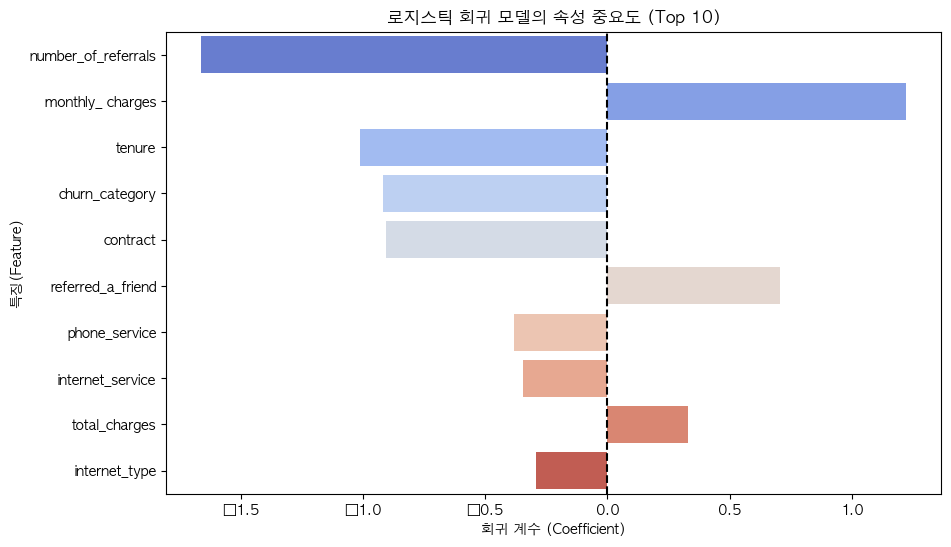

In [1103]:
# 특징별 중요도 확인
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_[0]
})
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()  # 절댓값 추가
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False)

print("Feature Importance (Coefficients):\n", coefficients)


coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr_model.coef_[0]
})

# 절댓값 기준 정렬
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
top_10_features = coefficients.sort_values(by="Abs_Coefficient", ascending=False).head(10)

# 변수 중요도 시각화 (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features["Coefficient"], y=top_10_features["Feature"], palette="coolwarm")
plt.axvline(x=0, color="black", linestyle="--")  # 0 기준선 추가
plt.title("로지스틱 회귀 모델의 속성 중요도 (Top 10)")
plt.xlabel("회귀 계수 (Coefficient)")
plt.ylabel("특징(Feature)")
plt.show()


**<로지스틱 회귀 모델 결과 분석>**  
로지스틱 회귀 모델 적용 결과 정확도 0.89로 높은 정확도를 보인다.  
고객의 클래스1(이탈)을 예측하는 것이 목적이기에 클래스1(이탈)의 재현율 또한 확인해야 한다.  
 클래스1의 재현율은 0.74로 클래스 0의 재현율 0.95에 비해 떨어지는 편이다.  

종속변수의 분포에서 확인했듯이 클래스1의 데이터 양에 비해 클래스0의 데이터가 많아 클래스0이 더 많이, 잘 학습됐을 수 있음.   

# Random Forest

In [1109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report


# Random Forest 초기화
random_forest = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)

# 모델 학습
random_forest.fit(X_train_scaled, y_train)

# 테스트 데이터에 대한 예측
y_pred_random_forest = random_forest.predict(X_test_scaled)

# 결과 평가
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')
report = classification_report(y_test, y_pred_random_forest)

print("Random Forest:")
print(f"Accuracy: {accuracy_random_forest}")
print(f"F1 Score: {f1_random_forest}")
print("Classification Report:\n", report)

Random Forest:
Accuracy: 0.9588360539389638
F1 Score: 0.9576669498753829
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1035
           1       1.00      0.84      0.92       374

    accuracy                           0.96      1409
   macro avg       0.97      0.92      0.94      1409
weighted avg       0.96      0.96      0.96      1409



**<랜덤 포레스트 모델 결과 분석>**  
랜덤 포레스트 모델의 정확도는 0.95로 매우 높은 정확도를 보인다. 또한 클래스1(이탈)에 대한 재현율 또한 0.84로 꽤 좋은 성과를 보여준다.


# 분석목표 2. 고객의 이탈을 예측하는 최적의 모델

*결론적으로, 정확도뿐만 아니라 재현율도 높게 나온 모델인 **RandomForest**가 이번 분석에 가장 적합한 모델이라는 결론을 내릴 수 있다.*

- 정확도 0.95 클래스1 재현율 0.84
- 클래스간의 성능차이가 로지스틱 회귀에 비해 적은 편이다.
- 이탈한 고객은 정확하게 예측하지만, 일부 이탈 고객을 놓치고 있어 이 부분에 대한 추가적 해결이 필요해 보인다. 